In [7]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Pauli, Statevector
from qiskit.converters import circuit_to_dag
from qiskit.transpiler import TransformationPass
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
import numpy as np
import numpy as np
import random
from qiskit import QuantumCircuit
from qiskit.circuit.library import RZGate, RXGate, RYGate, SGate, HGate, SGate, SdgGate, IGate
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit.transpiler import TransformationPass
import numpy as np
import random
from random import choices
import itertools
import scipy.stats
from math import pi, isclose

random_seed = 0  
random.seed(random_seed)
np.random.seed(random_seed)

observable = Pauli('XXXX')
nqubits = len(observable.to_label())
nshots = 4096

def least_squares_regression(noiseless_exp_vals, noisy_exp_vals):
    result = scipy.stats.linregress(noisy_exp_vals, noiseless_exp_vals)
    return (result.slope, result.intercept)

In [8]:
def apply_basis_rotation(circuit, observable):
    pauli_string = observable.to_label()  # convert the observable to a string of paulis
    num_qubits = len(pauli_string)  # number of qubits is length of the pauli string

    for idx, pauli in enumerate(pauli_string):
        qubit = idx  # qubit index matches the position of the pauli in the string
        # apply rotations to change measurement basis depending on pauli
        if pauli == 'X':
            circuit.h(qubit)        # rotate to measure in the x-basis
        elif pauli == 'Y':
            circuit.sdg(qubit)      # s-dagger then h transforms z-basis to y-basis
            circuit.h(qubit)
        elif pauli == 'Z' or pauli == 'I':
            pass  # z-basis is the default, no rotation needed
        else:
            raise ValueError(f"Unknown Pauli operator '{pauli}'.")

def expectation_value_from_counts(counts, nshots, observable):
    exp_val = 0
    pauli_string = observable.to_label()  # get the pauli string from the observable
    num_qubits = len(pauli_string)

    # iterate over each measured bitstring and its count
    for bitstring, count in counts.items():
        bitstring = bitstring.zfill(num_qubits)  # ensure correct length by padding with zeros
        eigenvalue = 1

        # calculate eigenvalue based on the measured bits and the pauli operators
        for idx in range(num_qubits):
            # note that bitstring[0] corresponds to the highest qubit index
            # but the pauli_string is indexed from left to right for qubits
            bit = bitstring[num_qubits - idx - 1]
            pauli = pauli_string[idx]

            # if pauli is identity, eigenvalue stays 1
            # if pauli is x, y, or z, eigenvalue flips to -1 if the bit is '1'
            if pauli == 'I':
                continue
            elif pauli in ['X', 'Y', 'Z']:
                if bit == '0':
                    eigenvalue *= 1
                else:
                    eigenvalue *= -1
            else:
                raise ValueError(f"Unknown Pauli operator '{pauli}'.")

        # accumulate weighted eigenvalues
        exp_val += eigenvalue * count

    # normalized expectation value over the total shots
    return exp_val / nshots

In [9]:
class RotationTransformer(TransformationPass):
    def __init__(self, N=0.3, seed=None):
        super().__init__()  # call the parent class constructor
        self.N = N  # store the probability threshold for random replacements
        # define exponents as integers corresponding to s^n, with n = 0,1,2,3
        self.clifford_exponents = np.array([0, 1, 2, 3])
        # calculate the corresponding angles: n * (π/2)
        self.clifford_angles = [n * (np.pi / 2) for n in self.clifford_exponents]
        self.random_state = random.Random(seed)  # initialize a local random state

    def run(self, dag):
        # mapping between rotation gate classes and their names
        rotation_gates = {
            RZGate: 'rz',
            RXGate: 'rx',
            RYGate: 'ry'
        }

        # iterate through each type of rotation gate
        for gate_cls, gate_name in rotation_gates.items():
            # find all nodes of the given gate class in the dag
            for node in list(dag.op_nodes(gate_cls)):
                angle = float(node.op.params[0])  # extract the rotation angle
                normalized_angle = angle % (2 * np.pi)  # normalize angle to [0, 2π)
                # check if the angle is one of the clifford angles
                is_clifford = any(
                    np.isclose(normalized_angle, cliff_angle, atol=1e-8)
                    for cliff_angle in self.clifford_angles
                )

                # if the angle is not clifford, possibly replace it with a clifford rotation
                if not is_clifford:
                    # draw a random number and compare with n to decide replacement
                    if self.random_state.random() < self.N:
                        # randomly select a clifford exponent
                        n = self.random_state.choice(self.clifford_exponents)
                        replacement_angle = n * (np.pi / 2)

                        # handle rz gate replacements
                        if gate_cls == RZGate:
                            if n == 0:
                                # this corresponds to an identity, so remove the gate
                                dag.remove_op_node(node)
                            else:
                                # create a new rz gate with the chosen clifford angle
                                replacement_gate = RZGate(replacement_angle)
                                dag.apply_operation_back(replacement_gate, node.qargs)

                        # handle rx gate replacements
                        elif gate_cls == RXGate:
                            if n == 0:
                                # identity, remove the gate
                                dag.remove_op_node(node)
                            else:
                                # build a small circuit to emulate rx as h s^n h
                                replacement_circuit = QuantumCircuit(1, name='RX_replacement')
                                replacement_circuit.h(0)
                                if n == 1:
                                    replacement_circuit.s(0)
                                elif n == 2:
                                    replacement_circuit.s(0)
                                    replacement_circuit.s(0)
                                elif n == 3:
                                    replacement_circuit.s(0)
                                    replacement_circuit.s(0)
                                    replacement_circuit.s(0)
                                replacement_circuit.h(0)
                                replacement_dag = circuit_to_dag(replacement_circuit)
                                # substitute the node in the dag with the new clifford sequence
                                dag.substitute_node_with_dag(node, replacement_dag)

                        # handle ry gate replacements
                        elif gate_cls == RYGate:
                            if n == 0:
                                # identity, remove the gate
                                dag.remove_op_node(node)
                            else:
                                # replace ry with s h s^n h sdg
                                replacement_circuit = QuantumCircuit(1, name='RY_replacement')
                                replacement_circuit.s(0)
                                replacement_circuit.h(0)
                                if n == 1:
                                    replacement_circuit.s(0)
                                elif n == 2:
                                    replacement_circuit.s(0)
                                    replacement_circuit.s(0)
                                elif n == 3:
                                    replacement_circuit.s(0)
                                    replacement_circuit.s(0)
                                    replacement_circuit.s(0)
                                replacement_circuit.h(0)
                                replacement_circuit.sdg(0)
                                replacement_dag = circuit_to_dag(replacement_circuit)
                                # substitute the node in the dag with the new clifford sequence
                                dag.substitute_node_with_dag(node, replacement_dag)
        return dag


In [10]:
def append_gates(qc):
    # repeat the pattern of gates 20 times
    for rep in range(20):
        # apply a hadamard to each qubit
        for qubit in range(nqubits):
            qc.h(qubit)
        # for even-indexed qubits, apply RY rotation with angle 1.25
        for qubit in range(nqubits)[::2]:
            qc.ry(1.25, qubit)
        # for odd-indexed qubits, apply RZ rotation with angle 1.31
        for qubit in range(nqubits)[1::2]:
            qc.rz(1.31, qubit)
        # for even-indexed qubits, apply a CNOT to the next qubit
        for qubit in range(nqubits)[::2]:
            qc.cx(qubit, qubit+1)
        # apply RZ rotation with angle -1.2 to even-indexed qubits
        for qubit in range(nqubits)[::2]:
            qc.rz(-1.2, qubit)
        # apply RZ rotation with angle 2.25 to odd-indexed qubits
        for qubit in range(nqubits)[1::2]:
            qc.rz(2.25, qubit)
        # apply an X gate to odd-indexed qubits
        for qubit in range(nqubits)[1::2]:
            qc.x(qubit)
        # rotate all qubits around the x-axis by π/2
        for qubit in range(nqubits):
            qc.rx(np.pi/2, qubit)
    return qc

# create a quantum circuit for the given number of qubits
qc = QuantumCircuit(nqubits)
append_gates(qc)
print(qc)

# create a RotationTransformer instance with given probability and seed
rotation_transformer = RotationTransformer(N=0.3, seed=random_seed)

# generate a list of 1000 transformed circuits without measurement
training_circuits_no_measurement_all = []
for _ in range(1000):
    # apply the transformer to qc (note: applying the same qc each time)
    transformed_qc = rotation_transformer(qc)
    training_circuits_no_measurement_all.append(transformed_qc)

     ┌───┐┌──────────┐     ┌──────────┐┌─────────┐   ┌───┐   ┌──────────┐»
q_0: ┤ H ├┤ Ry(1.25) ├──■──┤ Rz(-1.2) ├┤ Rx(π/2) ├───┤ H ├───┤ Ry(1.25) ├»
     ├───┤├──────────┤┌─┴─┐├──────────┤└──┬───┬──┘┌──┴───┴──┐└──┬───┬───┘»
q_1: ┤ H ├┤ Rz(1.31) ├┤ X ├┤ Rz(2.25) ├───┤ X ├───┤ Rx(π/2) ├───┤ H ├────»
     ├───┤├──────────┤└───┘├──────────┤┌──┴───┴──┐└──┬───┬──┘┌──┴───┴───┐»
q_2: ┤ H ├┤ Ry(1.25) ├──■──┤ Rz(-1.2) ├┤ Rx(π/2) ├───┤ H ├───┤ Ry(1.25) ├»
     ├───┤├──────────┤┌─┴─┐├──────────┤└──┬───┬──┘┌──┴───┴──┐└──┬───┬───┘»
q_3: ┤ H ├┤ Rz(1.31) ├┤ X ├┤ Rz(2.25) ├───┤ X ├───┤ Rx(π/2) ├───┤ H ├────»
     └───┘└──────────┘└───┘└──────────┘   └───┘   └─────────┘   └───┘    »
«                      ┌──────────┐┌─────────┐   ┌───┐   ┌──────────┐»
«q_0: ──────────────■──┤ Rz(-1.2) ├┤ Rx(π/2) ├───┤ H ├───┤ Ry(1.25) ├»
«     ┌──────────┐┌─┴─┐├──────────┤└──┬───┬──┘┌──┴───┴──┐└──┬───┬───┘»
«q_1: ┤ Rz(1.31) ├┤ X ├┤ Rz(2.25) ├───┤ X ├───┤ Rx(π/2) ├───┤ H ├────»
«     └──────────┘└───┘├──────────┤┌──┴──

In [11]:
# calculate the exact expectation value of the original circuit
psi_qc = Statevector.from_instruction(qc)  # get the statevector for the given circuit
exp_val_qc = psi_qc.expectation_value(observable).real  # compute the expectation value and take real part
print('Exact expectation value of the original circuit:', exp_val_qc)

# filter training circuits based on expectation value proximity
parity_threshold = 0.075  # define a threshold to select circuits close to the original expectation value

noiseless_exp_vals = []
training_circuits_no_measurement = []
for circuit in training_circuits_no_measurement_all:
    psi = Statevector.from_instruction(circuit)  # get statevector from the transformed circuit
    expectation_value = psi.expectation_value(observable).real  # compute its expectation value
    # check if the expectation value falls within the chosen threshold
    if (exp_val_qc - parity_threshold) <= expectation_value <= (exp_val_qc + parity_threshold):
        noiseless_exp_vals.append(expectation_value)
        training_circuits_no_measurement.append(circuit)

print(f'Number of training circuits within ±{parity_threshold} of the exact expectation value:', len(noiseless_exp_vals))

Exact expectation value of the original circuit: 0.2818887041748786
Number of training circuits within ±0.075 of the exact expectation value: 66


In [12]:
'''
    generate training circuits with measurement for noisy simulation on quantum devices
'''

# create a version of the original circuit with measurement
qr_qc = QuantumRegister(nqubits)          # quantum register
cr_qc = ClassicalRegister(nqubits)         # classical register
circ_qc = QuantumCircuit(qr_qc, cr_qc)
circ_qc.append(qc.to_instruction(), [qubit for qubit in range(nqubits)])  # replicate the original qc circuit
apply_basis_rotation(circ_qc, observable)  # apply basis rotations based on the observable
circ_qc.measure(qr_qc, cr_qc)              # add measurement

# =========================
# measurement and circuit preparation
# =========================

# prepare a list of training circuits, each with measurement
training_circuits_with_measurement = []
for circuit in training_circuits_no_measurement:
    qr = QuantumRegister(nqubits)          # new quantum register
    cr = ClassicalRegister(nqubits)         # new classical register
    circ = QuantumCircuit(qr, cr)
    circ.append(circuit.to_instruction(), qr)  # copy the training circuit
    apply_basis_rotation(circ, observable)      # apply basis rotations before measurement
    circ.measure(qr, cr)                        # measure all qubits
    training_circuits_with_measurement.append(circ)


In [13]:
'''
    adding a noise model to our simulation
'''

# create a generic backend with a given number of qubits and a fixed seed
device_backend = GenericBackendV2(nqubits, seed=23)
# create a noiseless simulator from the generic backend
sim_vigo = AerSimulator.from_backend(device_backend)

# =========================
# noise model and simulation
# =========================

noisy_exp_vals = []
# iterate over each of the training circuits with measurement
for idx, circuit in enumerate(training_circuits_with_measurement):
    # transpile the circuit for the simulator backend to optimize execution
    tqc = transpile(circuit, sim_vigo)
    
    # run the transpiled circuit on the noisy simulator
    job = sim_vigo.run(tqc, shots=nshots)
    result_noise = job.result()
    
    # retrieve measurement counts from the noisy simulation
    counts_noise = result_noise.get_counts()
    
    # if counts are returned, compute expectation value from those counts
    if counts_noise:
        noisy_exp_val = expectation_value_from_counts(counts_noise, nshots, observable)
        # append the computed noisy expectation value
        noisy_exp_vals.append(noisy_exp_val)
    else:
        # if no counts are returned, print a warning and append none
        print(f'no counts returned for circuit {idx+1}.')
        noisy_exp_vals.append(None)


In [14]:
import scipy
import scipy.optimize
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# convert lists to numpy arrays for easier manipulation
noisy_exp_vals = np.array(noisy_exp_vals)
noiseless_exp_vals = np.array(noiseless_exp_vals)

def least_squares_regression(X, y):
    # simple linear regression model without regularization
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    return model

def ridge_regression(X, y, alpha=1.0):
    # ridge regression adds l2 regularization to linear regression
    model = Ridge(alpha=alpha)
    model.fit(X.reshape(-1, 1), y)
    return model

def lasso_regression(X, y, alpha=1.0):
    # lasso regression adds l1 regularization, promoting sparsity
    model = Lasso(alpha=alpha)
    model.fit(X.reshape(-1, 1), y)
    return model

def polynomial_regression(X, y, degree=2):
    # polynomial regression fits a polynomial function of given degree
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X.reshape(-1, 1), y)
    return model

def ridge_polynomial_regression(X, y, degree=2, alpha=1.0):
    # ridge polynomial regression applies ridge regularization to polynomial regression
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model.fit(X.reshape(-1, 1), y)
    return model

def lasso_polynomial_regression(X, y, degree=2, alpha=1.0):
    # lasso polynomial regression applies l1 regularization to polynomial regression
    model = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha))
    model.fit(X.reshape(-1, 1), y)
    return model


In [15]:
# ordinary least squares regression
ls_model = least_squares_regression(noisy_exp_vals, noiseless_exp_vals)

# ridge regression
ridge_alpha = 0.01
ridge_model = ridge_regression(noisy_exp_vals, noiseless_exp_vals, alpha=ridge_alpha)

# lasso regression
lasso_alpha = 0.001
lasso_model = lasso_regression(noisy_exp_vals, noiseless_exp_vals, alpha=lasso_alpha)

# polynomial regression
poly_degree = 2
poly_model = polynomial_regression(noisy_exp_vals, noiseless_exp_vals, degree=poly_degree)

# ridge polynomial regression
ridge_poly_alpha = 0.01
ridge_poly_model = ridge_polynomial_regression(noisy_exp_vals, noiseless_exp_vals, degree=poly_degree, alpha=ridge_poly_alpha)

# lasso polynomial regression
lasso_poly_alpha = 0.001
lasso_poly_model = lasso_polynomial_regression(noisy_exp_vals, noiseless_exp_vals, degree=poly_degree, alpha=lasso_poly_alpha)


def print_linear_model_parameters(name, model):
    # function to print parameters (slope & intercept) for linear-type models
    if isinstance(model, LinearRegression) or isinstance(model, HuberRegressor) \
       or isinstance(model, Ridge) or isinstance(model, Lasso):
        slope = model.coef_[0]
        intercept = model.intercept_
        print(f'{name}:')
        print(f'  slope: {slope:.4f}, intercept: {intercept:.4f}\n')
    else:
        print(f'{name}: model type not recognized.\n')

def print_polynomial_model_parameters(name, model, degree):
    # function to print parameters for polynomial models
    # extracts the linear regression step inside the pipeline
    if hasattr(model, 'named_steps'):
        lr = model.named_steps.get('linearregression') or model.named_steps.get('ridge') or model.named_steps.get('lasso')
        intercept = lr.intercept_
        coefficients = lr.coef_
        print(f'{name}:')
        for i in range(1, degree + 1):
            print(f'  coefficient for x^{i}: {coefficients[i]:.4f}')
        print(f'  intercept: {intercept:.4f}\n')
    else:
        print(f'{name}: model type not recognized.\n')

# print linear models parameters
print_linear_model_parameters('ordinary least squares', ls_model)
print_linear_model_parameters(f'ridge regression (alpha={ridge_alpha})', ridge_model)
print_linear_model_parameters(f'lasso regression (alpha={lasso_alpha})', lasso_model)

# print polynomial models parameters
print_polynomial_model_parameters(f'polynomial regression (degree={poly_degree})', poly_model, poly_degree)
print_polynomial_model_parameters(f'ridge polynomial regression (degree={poly_degree}, alpha={ridge_poly_alpha})', ridge_poly_model, poly_degree)
print_polynomial_model_parameters(f'lasso polynomial regression (degree={poly_degree}, alpha={lasso_poly_alpha})', lasso_poly_model, poly_degree)


ordinary least squares:
  slope: 1.1163, intercept: 0.0382

ridge regression (alpha=0.01):
  slope: 0.9875, intercept: 0.0644

lasso regression (alpha=0.001):
  slope: 0.2556, intercept: 0.2135

polynomial regression (degree=2):
  coefficient for x^1: -0.2136
  coefficient for x^2: 3.1394
  intercept: 0.1752

ridge polynomial regression (degree=2, alpha=0.01):
  coefficient for x^1: 0.8407
  coefficient for x^2: 0.3919
  intercept: 0.0776

lasso polynomial regression (degree=2, alpha=0.001):
  coefficient for x^1: 0.2556
  coefficient for x^2: 0.0000
  intercept: 0.2135



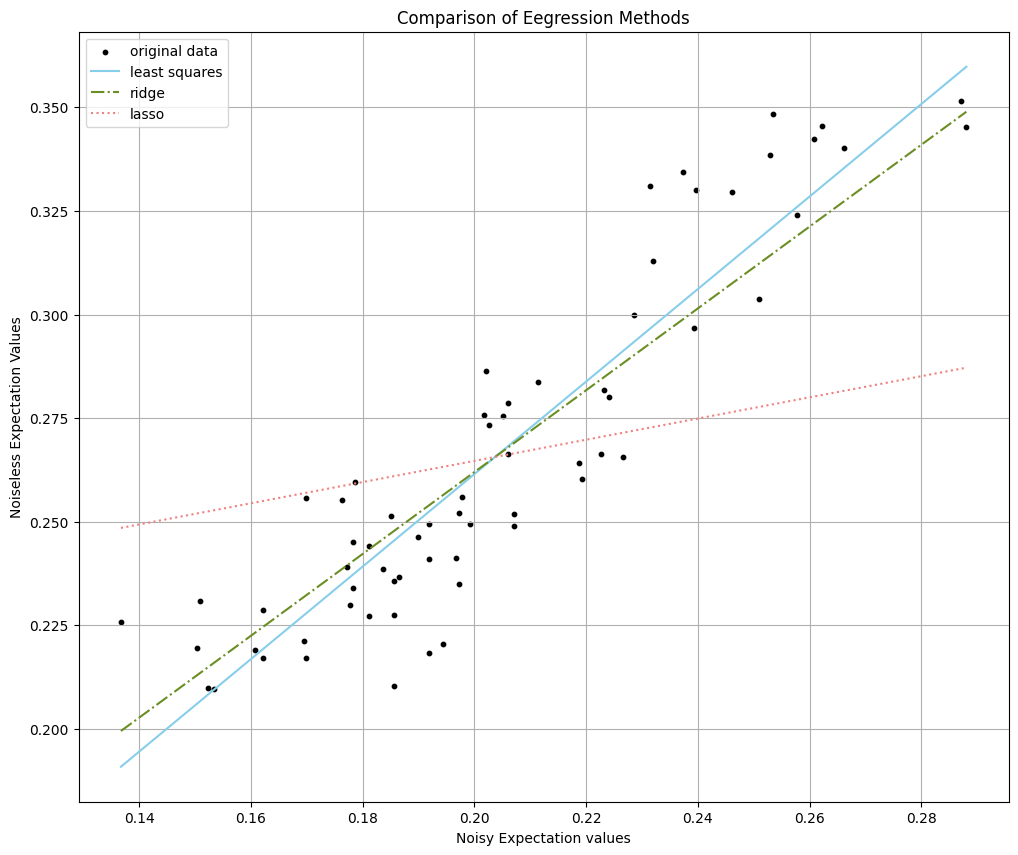

In [16]:
import matplotlib.pyplot as plt

# generate a range of x values (noisy expectation values) for plotting the fitted models
x_plot = np.linspace(min(noisy_exp_vals), max(noisy_exp_vals), 500).reshape(-1, 1)

plt.figure(figsize=(12, 10))
# plot the original data points as a scatter plot
plt.scatter(noisy_exp_vals, noiseless_exp_vals, color='black', s=10, label='original data')

# plot the prediction of the ordinary least squares model
plt.plot(x_plot, ls_model.predict(x_plot), color='skyblue', linestyle='-', label='least squares')

# plot the prediction of the ridge regression model
plt.plot(x_plot, ridge_model.predict(x_plot), color='olivedrab', linestyle='-.', label='ridge')

# plot the prediction of the lasso regression model
plt.plot(x_plot, lasso_model.predict(x_plot), color='lightcoral', linestyle=':', label='lasso')

# the polynomial regression models are commented out for now, but can be re-included by removing the comments
# plt.plot(x_plot, poly_model.predict(x_plot), 'c-', label=f'polynomial (deg={poly_degree})')
# plt.plot(x_plot, ridge_poly_model.predict(x_plot), 'y--', label=f'ridge polynomial (deg={poly_degree})')
# plt.plot(x_plot, lasso_poly_model.predict(x_plot), 'k-.', label=f'lasso polynomial (deg={poly_degree})')

# add a legend to differentiate the plotted lines and points
plt.legend()
plt.xlabel('Noisy Expectation values')
plt.ylabel('Noiseless Expectation Values')
plt.title('Comparison of Eegression Methods')
# enable grid for better readability
plt.grid(True)
# display the plot
plt.show()

In [17]:
'''
    prediction: run the original circuit and measure (= x_exact).
    then, apply the function x_exact = slope*x_noisy + intercept to obtain the mitigated value.
'''

# get the exact expectation value from the original circuit
psi_test = Statevector.from_instruction(qc)
exact_exp_val_test = psi_qc.expectation_value(observable)
print('exact expectation value: ', exact_exp_val_test)

# setup a noisy backend and simulate the original circuit with measurement
device_backend = GenericBackendV2(nqubits, seed=23)
sim_vigo = AerSimulator.from_backend(device_backend)

# transpile and run the circuit to obtain noisy measurements
tqc = transpile(circ_qc, backend=device_backend)
unmitigated_result = device_backend.run(tqc, shots=nshots).result()
unmitigated_counts = unmitigated_result.get_counts(0)
unmitigated_exp_val = expectation_value_from_counts(unmitigated_counts, nshots, observable)
print("unmitigated value: ", unmitigated_exp_val)

# define a threshold for deciding whether to apply mitigation
threshold = 0.009
noisy_value = unmitigated_exp_val

# use different regression models to predict a mitigated expectation value
# from the noisy measurement
mitigated_ls = ls_model.predict([[noisy_value]])[0]
mitigated_ridge = ridge_model.predict([[noisy_value]])[0]
mitigated_lasso = lasso_model.predict([[noisy_value]])[0]
mitigated_poly = poly_model.predict([[noisy_value]])[0]
mitigated_ridge_poly = ridge_poly_model.predict([[noisy_value]])[0]
mitigated_lasso_poly = lasso_poly_model.predict([[noisy_value]])[0]

# print out the mitigated expectation values for each model
print(f"Mitigated expectation value (Least Squares): {mitigated_ls:.4f}")
print(f"Mitigated expectation value (Ridge): {mitigated_ridge:.4f}")
print(f"Mitigated expectation value (Lasso): {mitigated_lasso:.4f}")
print(f"Mitigated expectation value (Polynomial): {mitigated_poly:.4f}")
print(f"Mitigated expectation value (Ridge Polynomial): {mitigated_ridge_poly:.4f}")
print(f"Mitigated expectation value (Lasso Polynomial): {mitigated_lasso_poly:.4f}")

# store mitigated values in a dictionary for easy iteration
mitigated_values = {
    'Least Squares': mitigated_ls,
    'Ridge': mitigated_ridge,
    'Lasso': mitigated_lasso,
    'Polynomial': mitigated_poly,
    'Ridge Polynomial': mitigated_ridge_poly,
    'Lasso Polynomial': mitigated_lasso_poly
}

# compare each mitigated value with the threshold and decide whether to apply it
for method, corrected_value in mitigated_values.items():
    # check if the correction is large enough to justify applying it
    if abs(noisy_value - corrected_value) >= threshold:
        final_value = corrected_value
        print(f'\nmitigation with {method}:')
        print(f'  mitigated expectation value: {final_value}')

        # calculate errors and improvements
        error_unmitigated = abs(unmitigated_exp_val - exact_exp_val_test)
        error_mitigated = abs(final_value - exact_exp_val_test)
        relative_error_unmitigated = error_unmitigated / abs(exact_exp_val_test) if exact_exp_val_test != 0 else np.inf
        relative_error_mitigated = error_mitigated / abs(exact_exp_val_test) if exact_exp_val_test != 0 else np.inf
        error_reduction = (error_unmitigated - error_mitigated) / error_unmitigated if error_unmitigated != 0 else 0

        # print out error metrics to evaluate the effectiveness of the mitigation
        print(f'  Error (unmitigated): {error_unmitigated:.4f}')
        print(f'  Error (mitigated with {method}): {error_mitigated:.4f}')
        print(f'  Relative error (unmitigated): {relative_error_unmitigated:.2%}')
        print(f'  Relative error (mitigated with {method}): {relative_error_mitigated:.2%}')
        print(f'  Error reduction with {method}: {error_reduction:.1%}.')
    else:
        # if the correction is too small, just keep the original unmitigated value
        final_value = noisy_value
        print(f'\n{method} correction not applied due to threshold; using unmitigated value.')


exact expectation value:  0.2818887041748786
unmitigated value:  0.1845703125
Mitigated expectation value (Least Squares): 0.2443
Mitigated expectation value (Ridge): 0.2467
Mitigated expectation value (Lasso): 0.2607
Mitigated expectation value (Polynomial): 0.2427
Mitigated expectation value (Ridge Polynomial): 0.2462
Mitigated expectation value (Lasso Polynomial): 0.2607

mitigation with Least Squares:
  mitigated expectation value: 0.24425568225930377
  Error (unmitigated): 0.0973
  Error (mitigated with Least Squares): 0.0376
  Relative error (unmitigated): 34.52%
  Relative error (mitigated with Least Squares): 13.35%
  Error reduction with Least Squares: 61.3%.

mitigation with Ridge:
  mitigated expectation value: 0.2467188092312078
  Error (unmitigated): 0.0973
  Error (mitigated with Ridge): 0.0352
  Relative error (unmitigated): 34.52%
  Relative error (mitigated with Ridge): 12.48%
  Error reduction with Ridge: 63.9%.

mitigation with Lasso:
  mitigated expectation value: 0

In [19]:
# run multiple trials to gather statistics about the error reduction for each mitigation method

# error reduction and percentage improvement lists for linear methods
error_reduction_ls = []
error_reduction_ridge = []
error_reduction_lasso = []

# lists to store mitigated values when the ls-based mitigation worsens the error
lasso_when_negative_ls = []
ridge_when_negative_ls = []
ls_when_negative_ls = []

# percentage improvement lists for linear methods
percentage_improvement_ls = []
percentage_improvement_ridge = []
percentage_improvement_lasso = []

# error reduction lists for polynomial methods
error_reduction_poly = []
error_reduction_ridge_poly = []
error_reduction_lasso_poly = []

# lists to track mitigations that worsen the error for polynomial methods
lasso_when_negative_poly = []
ridge_when_negative_poly = []
poly_when_negative_poly = []

# percentage improvement lists for polynomial methods
percentage_improvement_poly = []
percentage_improvement_ridge_poly = []
percentage_improvement_lasso_poly = []

psi_test = Statevector.from_instruction(qc)
exact_exp_val_test = psi_qc.expectation_value(observable)
print('Eact Expectation Value: ', exact_exp_val_test)

# initialize the simulator and backend
# replace 'genericbackendv2' with your actual backend if different
device_backend = GenericBackendV2(nqubits, seed=23)  
sim_vigo = AerSimulator.from_backend(device_backend)

# transpile the circuit once if it's the same for all trials
tqc = transpile(circ_qc, backend=device_backend)

n_trials = 5000  # number of trials

for trial in range(n_trials):
    # execute the circuit
    try:
        job = device_backend.run(tqc, shots=nshots).result()
        counts = job.get_counts(0) 

        # calculate the noisy expectation value
        unmitigated_exp_val = expectation_value_from_counts(counts, nshots, observable)

        # apply mitigation using each regression method
        mitigated_ls = ls_model.predict([[unmitigated_exp_val]])[0]
        mitigated_ridge = ridge_model.predict([[unmitigated_exp_val]])[0]
        mitigated_lasso = lasso_model.predict([[unmitigated_exp_val]])[0]

        # apply mitigation using polynomial regression methods
        mitigated_poly = poly_model.predict([[unmitigated_exp_val]])[0]
        mitigated_ridge_poly = ridge_poly_model.predict([[unmitigated_exp_val]])[0]
        mitigated_lasso_poly = lasso_poly_model.predict([[unmitigated_exp_val]])[0]

        # calculate errors
        error_unmitigated = abs(unmitigated_exp_val - exact_exp_val_test)
        error_ls = abs(mitigated_ls - exact_exp_val_test)
        error_ridge = abs(mitigated_ridge - exact_exp_val_test)
        error_lasso = abs(mitigated_lasso - exact_exp_val_test)

        error_poly = abs(mitigated_poly - exact_exp_val_test)
        error_ridge_poly = abs(mitigated_ridge_poly - exact_exp_val_test)
        error_lasso_poly = abs(mitigated_lasso_poly - exact_exp_val_test)

        # calculate error reductions
        reduction_ls = error_unmitigated - error_ls
        reduction_ridge = error_unmitigated - error_ridge
        reduction_lasso = error_unmitigated - error_lasso

        reduction_poly = error_unmitigated - error_poly
        reduction_ridge_poly = error_unmitigated - error_ridge_poly
        reduction_lasso_poly = error_unmitigated - error_lasso_poly

        # calculate percentage improvements
        perc_impr_ls = (reduction_ls / error_unmitigated) * 100 if error_unmitigated != 0 else 0
        perc_impr_ridge = (reduction_ridge / error_unmitigated) * 100 if error_unmitigated != 0 else 0
        perc_impr_lasso = (reduction_lasso / error_unmitigated) * 100 if error_unmitigated != 0 else 0

        perc_impr_poly = (reduction_poly / error_unmitigated) * 100 if error_unmitigated != 0 else 0
        perc_impr_ridge_poly = (reduction_ridge_poly / error_unmitigated) * 100 if error_unmitigated != 0 else 0
        perc_impr_lasso_poly = (reduction_lasso_poly / error_unmitigated) * 100 if error_unmitigated != 0 else 0

        # append to linear method lists
        percentage_improvement_ls.append(perc_impr_ls)
        percentage_improvement_ridge.append(perc_impr_ridge)
        percentage_improvement_lasso.append(perc_impr_lasso)

        error_reduction_ls.append(reduction_ls)
        error_reduction_ridge.append(reduction_ridge)
        error_reduction_lasso.append(reduction_lasso)

        # append to polynomial method lists
        percentage_improvement_poly.append(perc_impr_poly)
        percentage_improvement_ridge_poly.append(perc_impr_ridge_poly)
        percentage_improvement_lasso_poly.append(perc_impr_lasso_poly)

        error_reduction_poly.append(reduction_poly)
        error_reduction_ridge_poly.append(reduction_ridge_poly)
        error_reduction_lasso_poly.append(reduction_lasso_poly)

        # check for negative error reductions for linear methods
        if reduction_ls < 0:
            lasso_when_negative_ls.append(mitigated_lasso)
            ridge_when_negative_ls.append(mitigated_ridge)
            ls_when_negative_ls.append(mitigated_ls)

        # check for negative error reductions for polynomial methods
        if reduction_poly < 0:
            lasso_when_negative_poly.append(mitigated_lasso_poly)
            ridge_when_negative_poly.append(mitigated_ridge_poly)
            poly_when_negative_poly.append(mitigated_poly)

        if reduction_ridge_poly < 0:
            lasso_when_negative_poly.append(mitigated_lasso_poly)
            ridge_when_negative_poly.append(mitigated_ridge_poly)
            poly_when_negative_poly.append(mitigated_poly)

        if reduction_lasso_poly < 0:
            lasso_when_negative_poly.append(mitigated_lasso_poly)
            ridge_when_negative_poly.append(mitigated_ridge_poly)
            poly_when_negative_poly.append(mitigated_poly)

    except Exception as e:
        print(f"An error occured during trial {trial + 1}: {e}")
        continue  # skip to the next trial if an error occurs


Eact Expectation Value:  0.2818887041748786



Average error reductions:
  Least squares: 0.0590
  Ridge regression: 0.0599
  Lasso regression: 0.0618
  Polynomial regression: 0.0569
  Ridge polynomial regression: 0.0595
  Lasso polynomial regression: 0.0618

Average percentage improvements:
  Least squares: 77.21%
  Ridge regression: 78.40%
  Lasso regression: 79.39%
  Polynomial regression: 74.66%
  Ridge polynomial regression: 77.91%
  Lasso polynomial regression: 79.39%

Cases where least squares mitigation was negative:
  Number of cases: 7
  Average lasso mitigated value: 0.2777
  Average ridge mitigated value: 0.3123

Cases where polynomial mitigation was negative:
  Number of cases: 10
  Average lasso mitigated value: 0.2779
  Average ridge mitigated value: 0.3140
  Average polynomial mitigated value: 0.3202


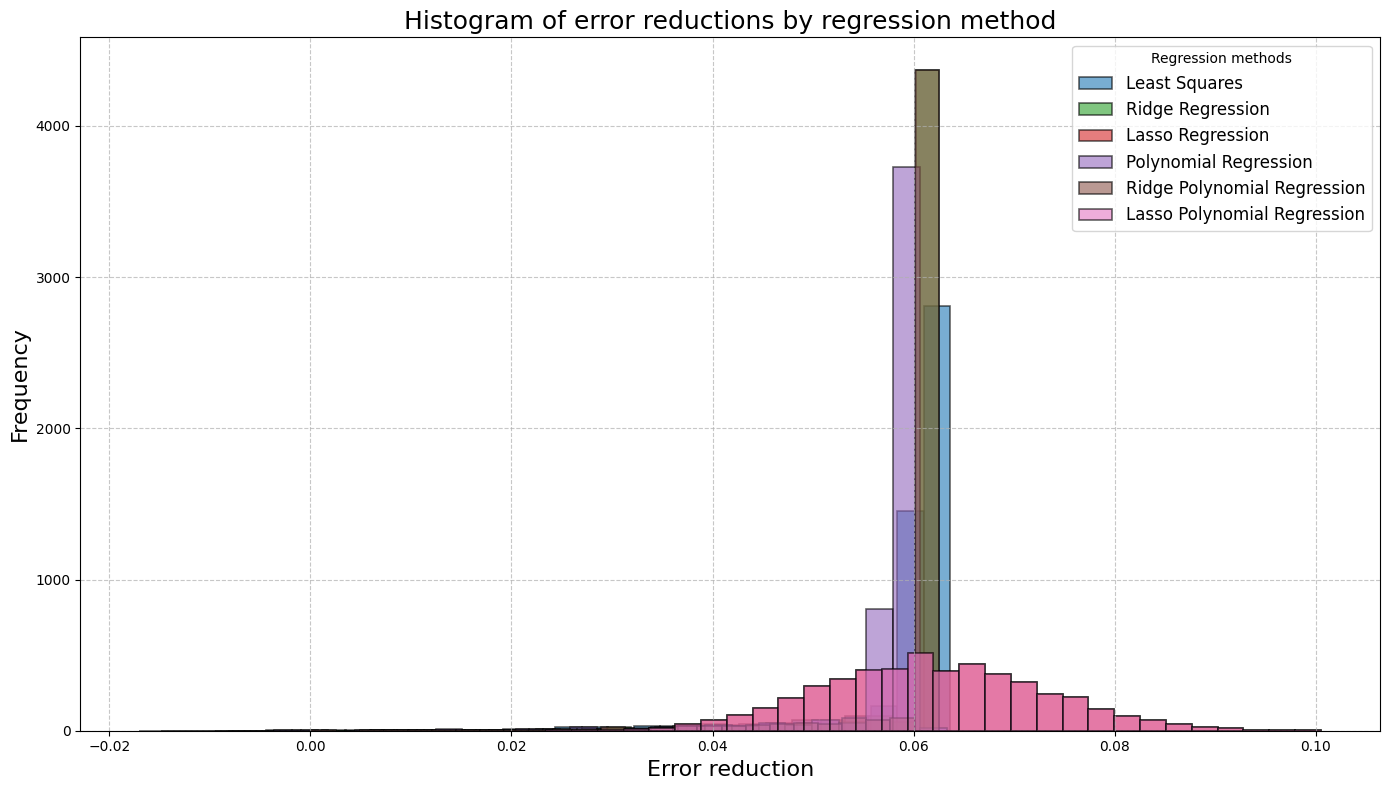

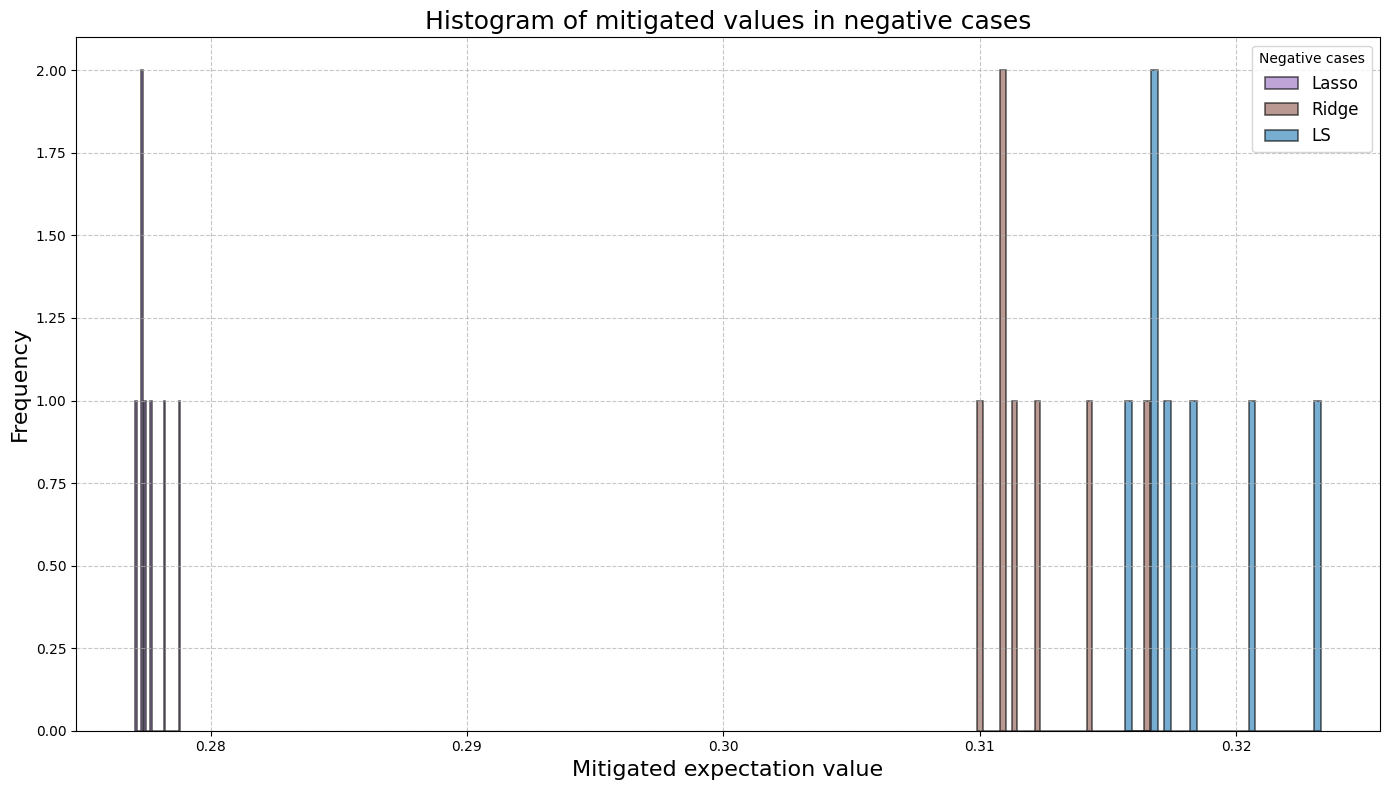

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# calculate average error reductions
avg_error_reduction_ls = np.mean(error_reduction_ls)
avg_error_reduction_ridge = np.mean(error_reduction_ridge)
avg_error_reduction_lasso = np.mean(error_reduction_lasso)

# calculate average error reductions for polynomial methods
avg_error_reduction_poly = np.mean(error_reduction_poly)
avg_error_reduction_ridge_poly = np.mean(error_reduction_ridge_poly)
avg_error_reduction_lasso_poly = np.mean(error_reduction_lasso_poly)

print("\nAverage error reductions:")
print(f"  Least squares: {avg_error_reduction_ls:.4f}")
print(f"  Ridge regression: {avg_error_reduction_ridge:.4f}")
print(f"  Lasso regression: {avg_error_reduction_lasso:.4f}")
print(f"  Polynomial regression: {avg_error_reduction_poly:.4f}")
print(f"  Ridge polynomial regression: {avg_error_reduction_ridge_poly:.4f}")
print(f"  Lasso polynomial regression: {avg_error_reduction_lasso_poly:.4f}")

# calculate average percentage improvements
avg_perc_impr_ls = np.mean(percentage_improvement_ls)
avg_perc_impr_ridge = np.mean(percentage_improvement_ridge)
avg_perc_impr_lasso = np.mean(percentage_improvement_lasso)

# calculate average percentage improvements for polynomial methods
avg_perc_impr_poly = np.mean(percentage_improvement_poly)
avg_perc_impr_ridge_poly = np.mean(percentage_improvement_ridge_poly)
avg_perc_impr_lasso_poly = np.mean(percentage_improvement_lasso_poly)

print("\nAverage percentage improvements:")
print(f"  Least squares: {avg_perc_impr_ls:.2f}%")
print(f"  Ridge regression: {avg_perc_impr_ridge:.2f}%")
print(f"  Lasso regression: {avg_perc_impr_lasso:.2f}%")
print(f"  Polynomial regression: {avg_perc_impr_poly:.2f}%")
print(f"  Ridge polynomial regression: {avg_perc_impr_ridge_poly:.2f}%")
print(f"  Lasso polynomial regression: {avg_perc_impr_lasso_poly:.2f}%")

# analyze cases where least squares mitigation was negative
if lasso_when_negative_ls and ridge_when_negative_ls:
    avg_lasso_neg_ls = np.mean(lasso_when_negative_ls)
    avg_ridge_neg_ls = np.mean(ridge_when_negative_ls)
    print("\nCases where least squares mitigation was negative:")
    print(f"  Number of cases: {len(lasso_when_negative_ls)}")
    print(f"  Average lasso mitigated value: {avg_lasso_neg_ls:.4f}")
    print(f"  Average ridge mitigated value: {avg_ridge_neg_ls:.4f}")
else:
    print("\nNo cases where least squares mitigation was negative.")

# analyze cases where polynomial mitigation was negative
if lasso_when_negative_poly and ridge_when_negative_poly:
    avg_lasso_neg_poly = np.mean(lasso_when_negative_poly)
    avg_ridge_neg_poly = np.mean(ridge_when_negative_poly)
    avg_poly_neg_poly = np.mean(poly_when_negative_poly)
    print("\nCases where polynomial mitigation was negative:")
    print(f"  Number of cases: {len(lasso_when_negative_poly)}")
    print(f"  Average lasso mitigated value: {avg_lasso_neg_poly:.4f}")
    print(f"  Average ridge mitigated value: {avg_ridge_neg_poly:.4f}")
    print(f"  Average polynomial mitigated value: {avg_poly_neg_poly:.4f}")
else:
    print("\nNo cases where polynomial mitigation was negative.")

# extract negative error reductions for each method
negative_error_reduction_ls = [x for x in error_reduction_ls if x < 0]
negative_error_reduction_ridge = [x for x in error_reduction_ridge if x < 0]
negative_error_reduction_lasso = [x for x in error_reduction_lasso if x < 0]

negative_error_reduction_poly = [x for x in error_reduction_poly if x < 0]
negative_error_reduction_ridge_poly = [x for x in error_reduction_ridge_poly if x < 0]
negative_error_reduction_lasso_poly = [x for x in error_reduction_lasso_poly if x < 0]

# visualization: compare error reductions
# create a dataframe for easier plotting
data = {
    'Least Squares': error_reduction_ls,
    'Ridge Regression': error_reduction_ridge,
    'Lasso Regression': error_reduction_lasso,
    'Polynomial Regression': error_reduction_poly,
    'Ridge Polynomial Regression': error_reduction_ridge_poly,
    'Lasso Polynomial Regression': error_reduction_lasso_poly
}

labels = ['Least Squares', 'Ridge Regression', 'Lasso Regression',
          'Polynomial Regression', 'Ridge Polynomial Regression', 'Lasso Polynomial Regression']

plot_styles = {
    'Least Squares': {'color': '#1f77b4', 'alpha': 0.6, 'edgecolor': 'black'},
    'Ridge Regression': {'color': '#2ca02c', 'alpha': 0.6, 'edgecolor': 'black'},
    'Lasso Regression': {'color': '#d62728', 'alpha': 0.6, 'edgecolor': 'black'},
    'Polynomial Regression': {'color': '#9467bd', 'alpha': 0.6, 'edgecolor': 'black'},
    'Ridge Polynomial Regression': {'color': '#8c564b', 'alpha': 0.6, 'edgecolor': 'black'},
    'Lasso Polynomial Regression': {'color': '#e377c2', 'alpha': 0.6, 'edgecolor': 'black'}
}

plt.figure(figsize=(14, 8))
bins = 30  # you can adjust the number of bins as needed

for label in labels:
    plt.hist(
        data[label],
        bins=bins,
        alpha=plot_styles[label]['alpha'],
        edgecolor=plot_styles[label]['edgecolor'],
        color=plot_styles[label]['color'],
        label=label,
        linewidth=1.2
    )

plt.title('Histogram of error reductions by regression method', fontsize=18)
plt.xlabel('Error reduction', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.legend(title='Regression methods', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# visualization: compare mitigated values in negative cases
negative_cases = {
    'Lasso (LS Negative)': lasso_when_negative_ls,
    'Ridge (LS Negative)': ridge_when_negative_ls,
    'Least Squares (LS Negative)': ls_when_negative_ls,
    # 'Lasso (Poly Negative)': lasso_when_negative_poly,
    # 'Ridge (Poly Negative)': ridge_when_negative_poly,
    # 'Polynomial (Poly Negative)': poly_when_negative_poly
}

# remove empty lists
negative_cases = {k: v for k, v in negative_cases.items() if v}

if negative_cases:
    df_negative = pd.DataFrame(negative_cases)
    neg_labels = df_negative.columns.tolist()
    
    # define colors and styles for negative cases
    neg_plot_styles = {
        'Lasso (LS Negative)': {'color': '#9467bd', 'alpha': 0.6, 'edgecolor': 'black', 'label': 'Lasso'},
        'Ridge (LS Negative)': {'color': '#8c564b', 'alpha': 0.6, 'edgecolor': 'black', 'label': 'Ridge'},
        'Least Squares (LS Negative)': {'color': '#1f77b4', 'alpha': 0.6, 'edgecolor': 'black', 'label': 'LS'},
        'Lasso (Poly Negative)': {'color': '#17becf', 'alpha': 0.6, 'edgecolor': 'black', 'label': 'Lasso'},
        'Ridge (Poly Negative)': {'color': '#bcbd22', 'alpha': 0.6, 'edgecolor': 'black', 'label': 'Ridge'},
        'Polynomial (Poly Negative)': {'color': '#aec7e8', 'alpha': 0.6, 'edgecolor': 'black', 'label': 'Poly'}
    }
    
    plt.figure(figsize=(14, 8))
    bins_neg = 30  # adjust bins as necessary

    for label in neg_labels:
        plt.hist(
            df_negative[label],
            bins=bins_neg,
            alpha=neg_plot_styles[label]['alpha'],
            edgecolor=neg_plot_styles[label]['edgecolor'],
            color=neg_plot_styles[label]['color'],
            label=neg_plot_styles[label]['label'],
            linewidth=1.2
        )
    
    plt.title('Histogram of mitigated values in negative cases', fontsize=18)
    plt.xlabel('Mitigated expectation value', fontsize=16)
    plt.ylabel('Frequency', fontsize=16)
    plt.legend(title='Negative cases', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("No negative mitigated cases to plot.")


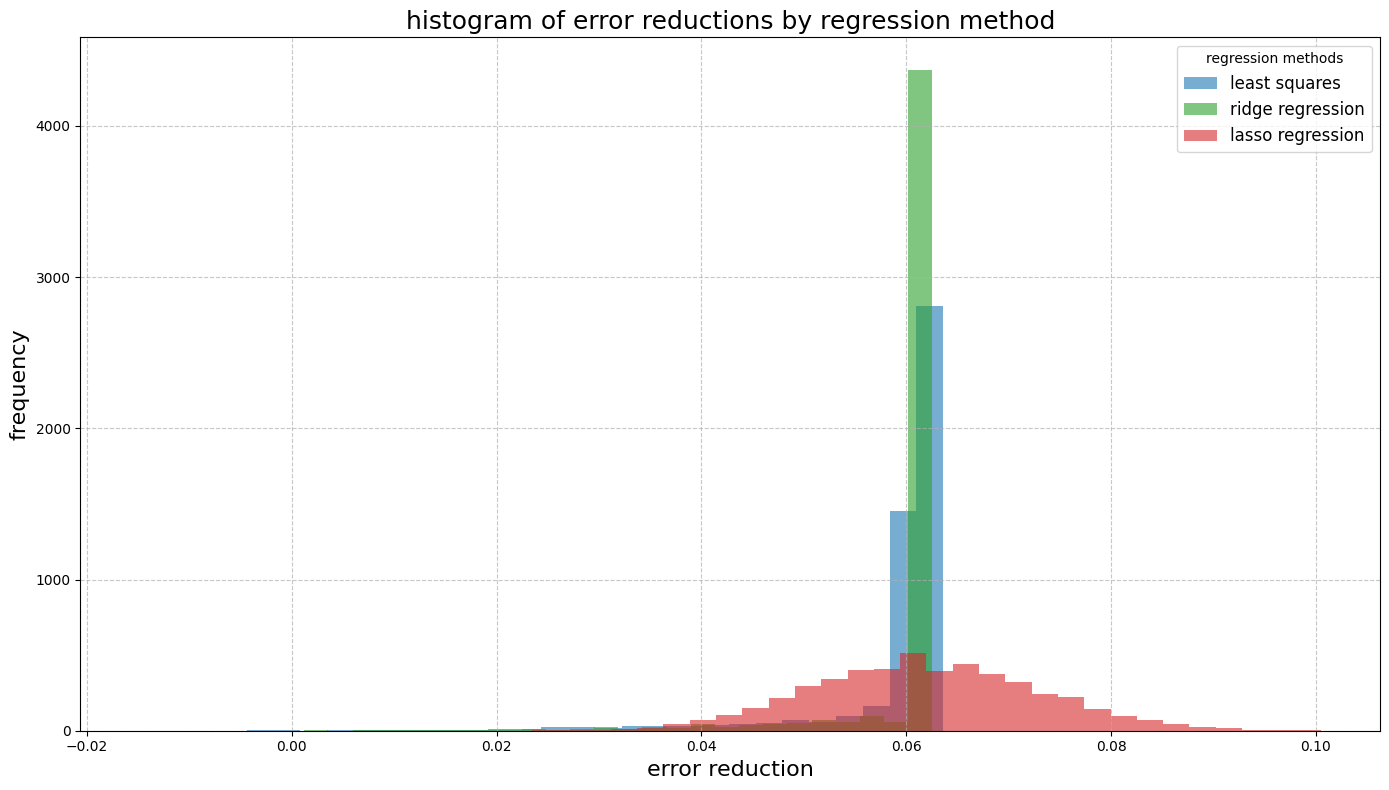

In [21]:
# create a dictionary of data containing error reductions for each method
data = {
    'least squares': error_reduction_ls,
    'ridge regression': error_reduction_ridge,
    'lasso regression': error_reduction_lasso,
    # 'polynomial regression': error_reduction_poly,
    # 'ridge polynomial regression': error_reduction_ridge_poly,
    # 'lasso polynomial regression': error_reduction_lasso_poly
}

# select which labels to plot
labels = ['least squares', 'ridge regression', 'lasso regression']

# define plotting styles for each method, using soft colors and no edge lines
plot_styles = {
    'least squares': {'color': '#1f77b4', 'alpha': 0.6, 'edgecolor': 'none'},
    'ridge regression': {'color': '#2ca02c', 'alpha': 0.6, 'edgecolor': 'none'},
    'lasso regression': {'color': '#d62728', 'alpha': 0.6, 'edgecolor': 'none'},
    'polynomial regression': {'color': '#9467bd', 'alpha': 0.6, 'edgecolor': 'none'},
    'ridge polynomial regression': {'color': '#8c564b', 'alpha': 0.6, 'edgecolor': 'none'},
    'lasso polynomial regression': {'color': '#e377c2', 'alpha': 0.6, 'edgecolor': 'none'}
}

# create a figure for the histogram
plt.figure(figsize=(14, 8))

# define the number of bins for the histogram
bins = 30

# plot a histogram for each selected method
for label in labels:
    plt.hist(
        data[label],
        bins=bins,
        alpha=plot_styles[label]['alpha'],
        edgecolor=plot_styles[label]['edgecolor'],
        color=plot_styles[label]['color'],
        label=label,
        linewidth=1.2
    )

# set plot title and labels
plt.title('histogram of error reductions by regression method', fontsize=18)
plt.xlabel('error reduction', fontsize=16)
plt.ylabel('frequency', fontsize=16)

# add a legend to distinguish the regression methods
plt.legend(title='regression methods', fontsize=12)

# enable a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# adjust layout for better appearance
plt.tight_layout()

# display the plot
plt.show()


In [12]:
data = {
    'Least Squares': error_reduction_ls,
    'Ridge Regression': error_reduction_ridge,
    'Lasso Regression': error_reduction_lasso,
    # 'Polynomial Regression': error_reduction_poly,
    # 'Ridge Polynomial Regression': error_reduction_ridge_poly,
    # 'Lasso Polynomial Regression': error_reduction_lasso_poly
}

# for d in data.values():
#     for i in d:
#         print(i)

0.01249566856909333
0.011276523110918368
0.01171193220312372
0.011537768566241585
0.01204284311319978
0.013261988571374735
0.00055076610931859
0.012077675840576209
-0.010423121290195902
0.0127046649333519
0.011502935838865164
0.01209509220426442
0.011938344931070495
0.012582750387534404
0.012843995842857607
0.012809163115481179
0.011729348566811931
0.012304088568522983
0.011241690383541947
0.01371481402726829
0.012478252205405119
0.012251839477458344
0.011607434020994428
0.012965910388675103
0.01204284311319978
0.011886095840005856
0.01176418129418836
0.011886095840005856
0.012617583114910833
0.013209739480310095
0.01136360492935945
0.011537768566241585
0.012269255841146555
0.012513084932781547
0.012460835841716908
0.012513084932781547
0.012338921295899412
0.012408586750652262
0.012025426749511563
0.011868679476317645
0.012286672204834773
0.011346188565671239
0.012913661297610464
0.012025426749511563
0.012129924931640848
0.012251839477458344
0.011485519475176939
0.012408586750652262
0.

In [22]:
# create a dictionary with negative error reductions for each method
negative_error_data = {
    'least squares': negative_error_reduction_ls,
    'ridge regression': negative_error_reduction_ridge,
    'lasso regression': negative_error_reduction_lasso,
    'polynomial regression': negative_error_reduction_poly,
    'ridge polynomial regression': negative_error_reduction_ridge_poly,
    'lasso polynomial regression': negative_error_reduction_lasso_poly
}

# filter out methods that have no negative error reductions
negative_error_data = {k: v for k, v in negative_error_data.items() if v}

# create a dataframe where each column corresponds to a method’s negative error reductions
# pd.series is used to convert lists of values into series, ensuring proper alignment
df_negative_error = pd.DataFrame(dict((k, pd.Series(v)) for k, v in negative_error_data.items()))

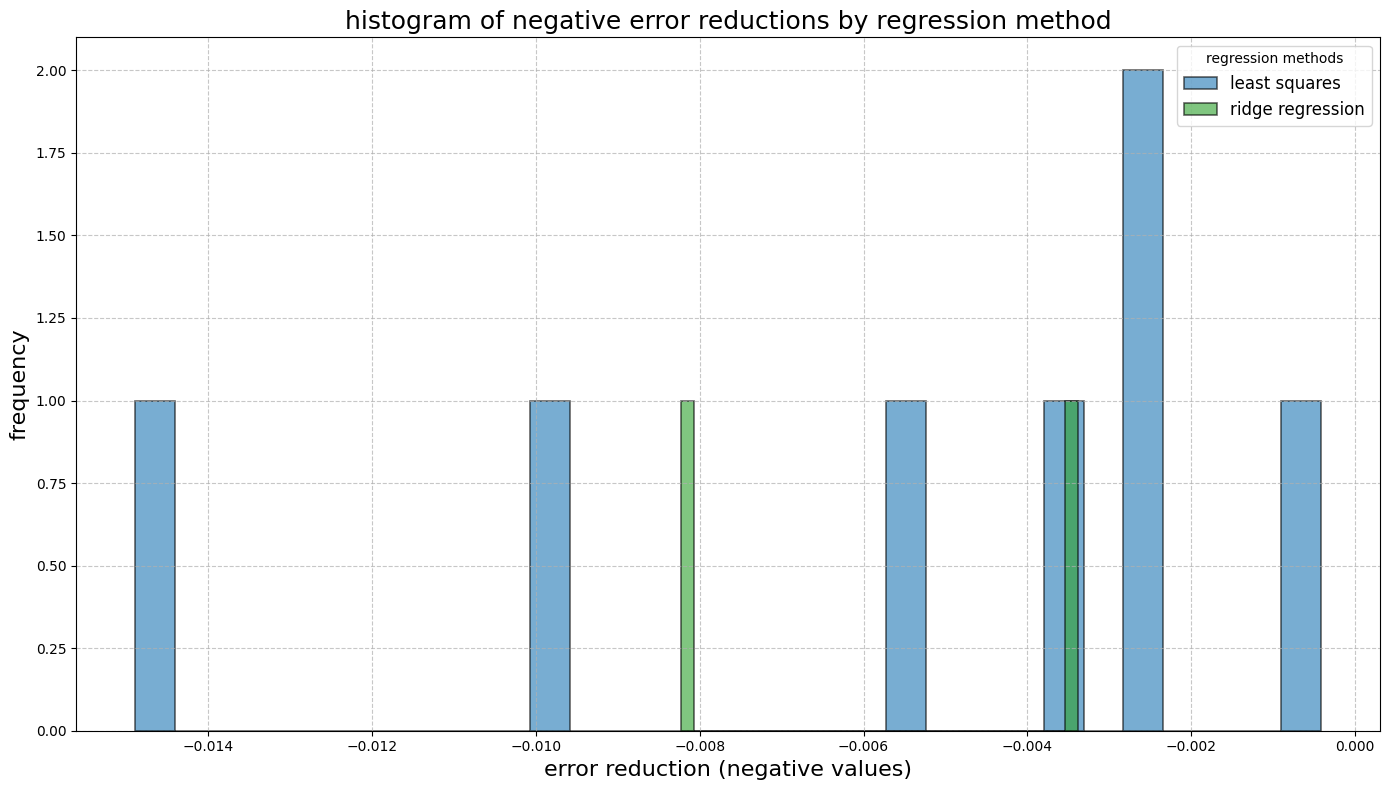

In [23]:
# visualization: histogram of negative error reductions
plt.figure(figsize=(14, 8))
bins_neg = 30  # adjust as needed

# define colors and styles for negative error reductions
negative_plot_styles = {
    'least squares': {'color': '#1f77b4', 'alpha': 0.6, 'edgecolor': 'black'},
    'ridge regression': {'color': '#2ca02c', 'alpha': 0.6, 'edgecolor': 'black'},
    'lasso regression': {'color': '#d62728', 'alpha': 0.6, 'edgecolor': 'black'},
    # 'polynomial regression': {'color': '#9467bd', 'alpha': 0.6, 'edgecolor': 'black'},
    # 'ridge polynomial regression': {'color': '#8c564b', 'alpha': 0.6, 'edgecolor': 'black'},
    # 'lasso polynomial regression': {'color': '#e377c2', 'alpha': 0.6, 'edgecolor': 'black'}
}

for method, style in negative_plot_styles.items():
    if method in df_negative_error.columns:
        plt.hist(
            df_negative_error[method].dropna(),
            bins=bins_neg,
            alpha=style['alpha'],
            edgecolor=style['edgecolor'],
            color=style['color'],
            label=method,
            linewidth=1.2
        )

plt.title('histogram of negative error reductions by regression method', fontsize=18)
plt.xlabel('error reduction (negative values)', fontsize=16)
plt.ylabel('frequency', fontsize=16)
plt.legend(title='regression methods', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

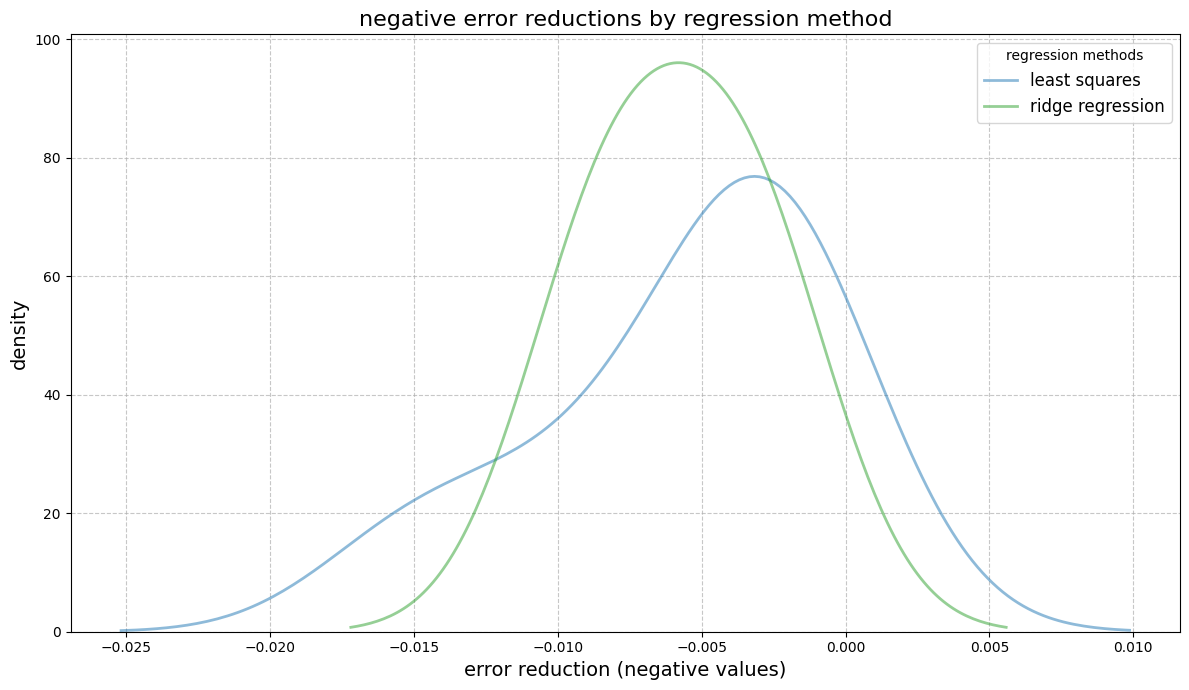

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# dictionary containing negative error reductions for certain regression methods
negative_error_data = {
    'least squares': negative_error_reduction_ls,
    'ridge regression': negative_error_reduction_ridge,
    'lasso regression': negative_error_reduction_lasso,
    # 'Polynomial Regression': negative_error_reduction_poly,
    # 'Ridge Polynomial Regression': negative_error_reduction_ridge_poly,
    # 'Lasso Polynomial Regression': negative_error_reduction_lasso_poly
}

# iterate through each method and its corresponding negative error reductions
for method, reductions in negative_error_data.items():
    # check if the plot_styles dictionary has a 'label' for this method; if not, use the method name
    if 'label' in plot_styles[method]:
        method_label = plot_styles[method]['label']
    else:
        method_label = method

    # use seaborn’s kdeplot to plot the density of negative error reductions
    sns.kdeplot(
        reductions,
        label=method_label,
        color=plot_styles[method]['color'],
        linewidth=2,
        alpha=0.5     # make the plot slightly transparent
    )

# set plot title and axes labels
plt.title('negative error reductions by regression method', fontsize=16)
plt.xlabel('error reduction (negative values)', fontsize=14)
plt.ylabel('density', fontsize=14)

# add a legend to identify each regression method
plt.legend(title='regression methods', fontsize=12)

# add grid lines for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# adjust layout and save the figure
plt.tight_layout()
plt.savefig("Neg.png")
# plt.show() 


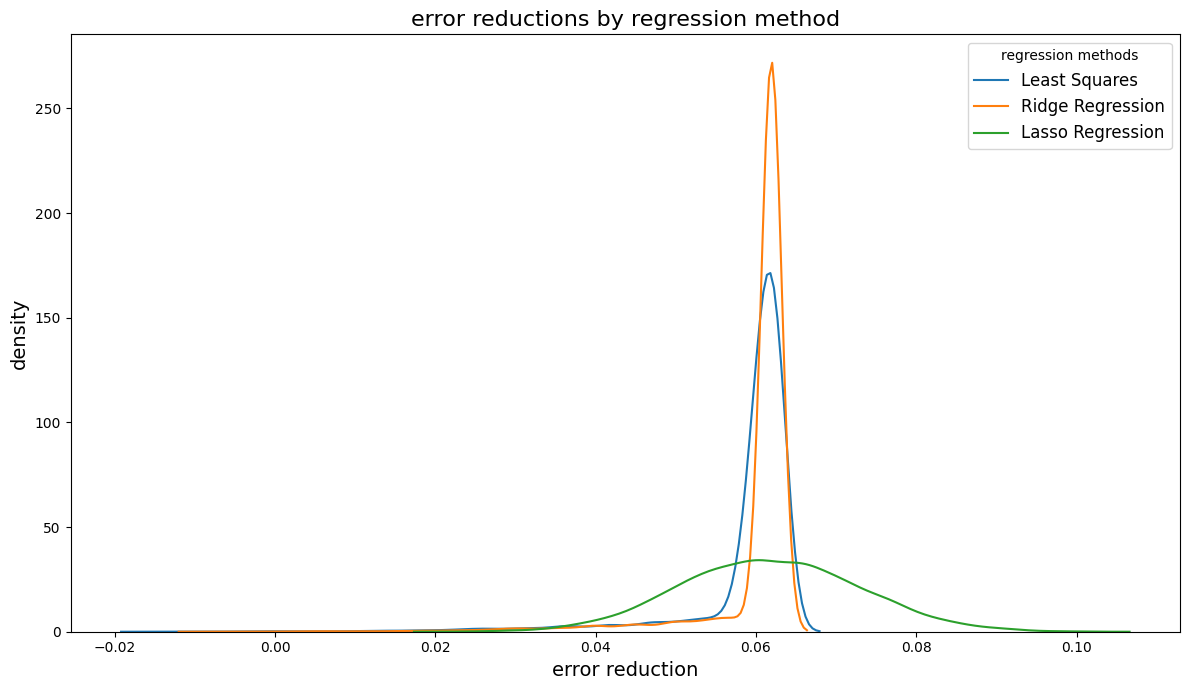

In [26]:
# define the sample size for down-sampling data
sample_size = 5000  # you can adjust this based on the size of your dataset

# function to sample data from a list up to a given size
def sample_data(data_list, size):
    np.random.seed(0)  # set a seed for reproducibility
    if len(data_list) > size:
        # if data_list is larger than sample_size, randomly select 'size' elements without replacement
        return np.random.choice(data_list, size=size, replace=False)
    # if data_list is smaller or equal to size, return it as is
    return data_list

# define which methods to include in the plot
labels = ['Least Squares', 'Ridge Regression', 'Lasso Regression']

# create a dictionary of sampled data for each method
sampled_data = {
    'Least Squares': sample_data(error_reduction_ls, sample_size),
    'Ridge Regression': sample_data(error_reduction_ridge, sample_size),
    'Lasso Regression': sample_data(error_reduction_lasso, sample_size)
}

# plotting the sampled data using a kernel density estimate (kde) plot for each method
plt.figure(figsize=(12, 7))
for label in labels:
    # kdeplot will show the distribution shape of the error reductions for each method
    sns.kdeplot(sampled_data[label], label=label, alpha=1)

# set the title and axis labels
plt.title('error reductions by regression method', fontsize=16)
plt.xlabel('error reduction', fontsize=14)
plt.ylabel('density', fontsize=14)

# add a legend to distinguish each method
plt.legend(title='regression methods', fontsize=12)

# adjust layout for a nicer fit
plt.tight_layout()

# save the figure to a file with a transparent background
plt.savefig("KDE.png", transparent=True)
# plt.show() 

In [27]:
# for i in range(len(error_reduction_ls)):
#     if(error_reduction_ls[i] > 50):
#         print(error_reduction_ls[i])

print(max(error_reduction_ls), max(error_reduction_ridge), max(error_reduction_lasso))
print(min(error_reduction_ls), min(error_reduction_ridge), min(error_reduction_lasso))
print(np.average(error_reduction_ls), np.average(error_reduction_ridge), np.average(error_reduction_lasso))

0.06360511262161195 0.06255588893470027 0.10050077230112975
-0.014887289707150753 -0.008231606187325047 0.023441079882164317
0.05899386510728112 0.0598864018447312 0.061757921470149316
